## Introduction

Your goal is to assess the trade-offs of stability, accuracy, and run-time of a least two methods applied to two ODE systems. 

The first ODE system is two proteins degrading. The ODEs are:

\begin{align*}
\frac{dy_1}{dt}&=&-\alpha y_1\\
\frac{dy_2}{dt}&=&-\beta y_2\\
\end{align*}

where $\alpha=0.1$ and $\beta=0.2$.

The second ODE system is the Lotka-Volterra model of predator-prey populations and their interactions. You can check out the Wikipedia entry to learn more, but what you need to know here is that it is a 2-ODE system and that, with the right parameter values, it leads to oscillations. The ODEs are:

\begin{align*}
\frac{dx}{dt} &= \alpha x -\beta x y\\
\frac{dy}{dt} &= -\gamma y + \delta x y\\
\end{align*}

where $\alpha=0.25$, $\beta=0.01$, $\gamma=1$, and $\delta=0.01$.


## The Project

Consider three methods -- the forward Euler method, the explicit trapezoidal method, and an adaptive step-size forward Euler method (that uses the trapezoidal method to estimate the local error).

Compare the performance of each of your three methods on the degradation and predator-prey systems.  In your analysis, you will want to consider both runtime (we want our answer as quickly as possible) and accuracy (how close is the method to the "true" solution?). For the first two methods, be sure to consider the effect of step-size on accuracy and speed. For the third, be sure to analyze the step-sizes chosen and the effect of error tolerance on the step size. The ideal graph plots accuracy versus runtime for different methods used to solve the same model (one line for each method, one step-size for each point on the line, where the step-size for the adaptive method is the average step-size chosen by the method).


## Extensions

This project will be more interesting if you tackle one or more of these extensions.  Feel free to develop your own extension. And, as always, a particularly thorough analysis is smiled upon.

<ul>
<li> Analyze the van der Pol oscillator in addition to the models above. The equations for it are:
\begin{align*}
\frac{dy_1}{dt} &= y_2\\
\frac{dy_2}{dt} &= \mu (1-y_1^2)y_2 - y_1.\\
\end{align*}
When $\mu=50$, the period of oscillation is long (nearly 80) and the system is stiff. When $\mu=1$, the period is short (approximately 6) and the system is not stiff. We expect implicit methods to perform better on the stiff system. Demonstrate that it is better to use the implicit method when $\mu=50$, but that explicit methods are perfectly adequate when $\mu=1$.
<li> Implement additional explicit Runge-Kutta methods. In particular, it would be nice to see the results of a fourth order method.
<li> Implement Adams-Bashforth method (this should be covered in Lecture 15).
<li> Implement the Backward Euler method and compare its results to those of your other methods. (Note that backward euler is an implicit method, which means the solution at the new time step appears on both sides of the equation and, therefore, requires additional computation. For example, you will need to use Newton's method to approximately solve a nonlinear system of algebraic equations. If you chose to use Backward Euler, consult Stephanie before writing code.)

</ul>

## Notes

### Timing
To time your method, use the <a href="https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit">%timeit</a> magic command. You use it either for a single line of code, e.g.   

<code>
%timeit (t,y) = forwardEuler( protein_degradation, np.arange(0,50,0.01), np.array([1,1]), params)
</code>

or to time an entire cell, e.g.
<code>
%%timeit
(t,y) = forwardEuler( protein_degradation, np.arange(0,50,0.01), np.array([1,1]), params)   
</code>

If you use it in cell mode, then be sure to put just the solving code in the cell. Put any plotting code in a different cell. 

Regardless of which mode you use, you probably need to rerun the solving code before you do so. Stephanie has found that timeit doesn't actually do the assignment into (t,y) the way she was expecting it to. The safest thing to do is use a cell for just timing, and then a cell for re-running and plotting.

### Accuracy
To compute the accuracy of your method, compare its output to the output of scipy.integrate.solve_ivp (which will stand in for the "true solution"). Set its relative tolerance so that it is "tight" (i.e. you will tolerate very little error; rtol=1e-8).  Error calculations should be performed by comparing the solutions to $y$ at the same time steps, but you will likely be comparing the true solution to outputs from methods using lots of different time steps. The easiest way to handle this is to call scipy.integrate.solve_ivp for each unique set of timesteps you have. For example, when you use the adaptive step size function, you do not know ahead of time which timesteps you will have, so run that first, and use the output to set the t_eval parameter for solve_ivp:
<code>
(t,y,steps) = forwardEulerAdaptiveStepSize( protein_degradation, 0, 50, 
    np.array([1,1]), params, 1e-4)
sol = scipy.integrate.solve_ivp(fun=protein_degradation, t_span=(0,50), y0=(1,1), 
                                method='LSODA', t_eval=t, args=[params], rtol=1e-8, atol=1e-8 )
</code>
    
To compute the error, use one of the methods we described in Lecture 12 (first, compute the error at each time point, then summarize it over time).


# Model 1:
Starting with the first ODE system which is two proteins degrading. The ODEs are:

\begin{align*}
\frac{dy_1}{dt}&=&-\alpha y_1\\
\frac{dy_2}{dt}&=&-\beta y_2\\
\end{align*}

where $\alpha=0.1$ and $\beta=0.2$.



### First Order Function for Model 1:
We can make a function to represent the degradation of the two proteins as shown below:

In [7]:
import numpy as np
def protien_degradation( t, y, params):
    '''

    :param t:
    :param y:
    :param params:
    :return:
    '''
    dy1_dt = -params[0] * y[0];
    dy2_dt = -params[1] * y[1];

    return np.array((dy1_dt,dy2_dt))


### Forward Eurler method for Protien Simulation

In [8]:
def forwardEuler( fn, t, y0, params ):
    """ [t,y] = forwardEuler( fn, t, y0, params )
    Given a function handle fn for dydt, find the value of
    y at timepoints t, given y(0) = y0.
    fn takes t, y, and params as input.
    t is 1-dimensional (NT,)
    y0 is 2-dimensional (NY,NT)
    """
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        yprime = fn(t[i-1],y[:,i-1],params);
        y[:,i] = y[:,i-1] + h*yprime;

    return (t,y)

### Testing the Accuracy of different simulation methods for Model 1

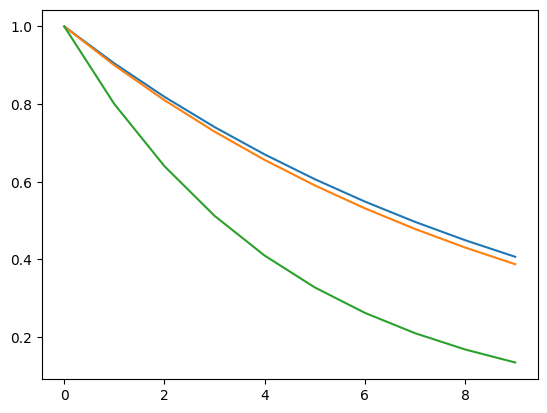

In [14]:
import scipy.integrate
import matplotlib.pyplot as plt
dt = 1
y0 = np.array((1,1))
params = (0.1,0.2)
t = np.arange(0,10,dt)
tru_y = np.exp( -params[0]*t)
(t,y) = forwardEuler( protien_degradation, t, y0=y0, params=params)

plt.plot(t, tru_y)
plt.plot(t, y.T);


## Model 2:
The second ODE system is the Lotka-Volterra model of predator-prey populations and their interactions. You can check out the Wikipedia entry to learn more, but what you need to know here is that it is a 2-ODE system and that, with the right parameter values, it leads to oscillations. The ODEs are:

\begin{align*}
\frac{dx}{dt} &= \alpha x -\beta x y\\
\frac{dy}{dt} &= -\gamma y + \delta x y\\
\end{align*}

where $\alpha=0.25$, $\beta=0.01$, $\gamma=1$, and $\delta=0.01$.

Here are the constants for the Lokta-Volterra predator-prey model.

In [5]:
predator_constants = np.array((0.25,0.01))


# Methods of Simulations

### The Euler Method

In [15]:


def forwardEuler( fn, t, y0, params ):
    """ [t,y] = forwardEuler( fn, t, y0, params )
    Given a function handle fn for dydt, find the value of
    y at timepoints t, given y(0) = y0.
    fn takes t, y, and params as input.
    t is 1-dimensional (NT,)
    y is 2-dimensional (NY,NT)
    """
    y = np.zeros( (y0.size,t.size) )
    y[:,0] = y0;
    for i in range(1,t.size):
        h = t[i]-t[i-1];
        yprime = fn(t[i-1],y[:,i-1],params);
        y[:,i] = y[:,i-1] + h*yprime;

    return (t,y)


### Accuracy of Simulation methods for Model 1

In [ ]:
time_steps = np.arange

<hr style="border:2px solid gray"> </hr>

Acknowledgements

*Replace this text with links to external resources and thanks to people you worked with.*